In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

loc = 'SlumClassifier/assets/model.keras'
PATH = 'SlumClassifier'
IMG_HEIGHT = 512
IMG_WIDTH = 512
model = tf.keras.models.load_model(loc, compile=False)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
test_image_generator = ImageDataGenerator(rescale=1./255)

test_data_gen = test_image_generator.flow_from_directory(
                    PATH,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=5,
                    classes=['test'],
                    shuffle=False)

probabilities = model.predict(test_data_gen).flatten()
probabilities
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% Slum")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% Not Slum")
    plt.show()

Found 10 images belonging to 1 classes.
1/2 [==============>...............] - ETA: 0s

2024-03-01 11:21:34.407410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 0s 86ms/step


In [4]:
demo_images = [test_data_gen[0][0][i] for i in range(5)] + [test_data_gen[1][0][i] for i in range(5)]
ims = np.array(demo_images)
probs = model.predict(ims).flatten()
ims.shape

1/1 [==============================] - 0s 162ms/step


(10, 512, 512, 3)

In [7]:
images = [i.reshape(512, 512, 3) for i in demo_images]
images[0].shape

(512, 512, 3)

In [8]:
import lime
from lime import lime_image

/Users/divyamkumar/anaconda3/envs/forget/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
explainer = lime_image.LimeImageExplainer()

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def func(predictable):
    # predictable = rgb2gray(predictable)
    pred = predictable.reshape(10, 512, 512, 3)
    return model.predict(pred)


In [ ]:
explanation = [explainer.explain_instance(images[i].astype('float32'), func, labels = ["Slum", "Not Slum"]) for i in range(10)]

In [14]:
from skimage.segmentation import mark_boundaries
print(explanation)

[<lime.lime_image.ImageExplanation object at 0x28c965e10>, <lime.lime_image.ImageExplanation object at 0x28c92b190>, <lime.lime_image.ImageExplanation object at 0x2d9ce1750>, <lime.lime_image.ImageExplanation object at 0x2d9cc7d90>, <lime.lime_image.ImageExplanation object at 0x2de8dc8d0>, <lime.lime_image.ImageExplanation object at 0x2de8c41d0>, <lime.lime_image.ImageExplanation object at 0x31345bb90>, <lime.lime_image.ImageExplanation object at 0x34cd51750>, <lime.lime_image.ImageExplanation object at 0x3134a3190>, <lime.lime_image.ImageExplanation object at 0x33a5db850>]


In [36]:
temps, masks = [], []
for i in explanation:
    temp, mask = i.get_image_and_mask(i.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
    temps.append(temp)
    masks.append(mask)

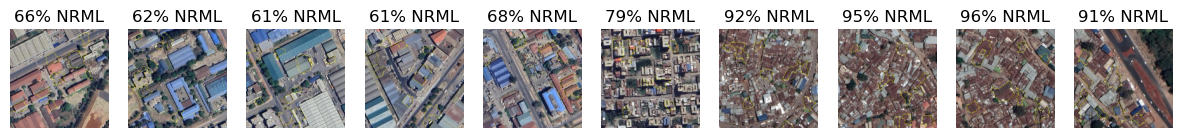

In [47]:
fig, axes = plt.subplots(1, 10, figsize=(15, 15))

for i in range(10):
        axes[i].imshow(mark_boundaries(temps[i], masks[i]))
        axes[i].axis('off')
        axes[i].set_title("%.0f" % ((probs[i])*100) + "% NRML")
plt.show()

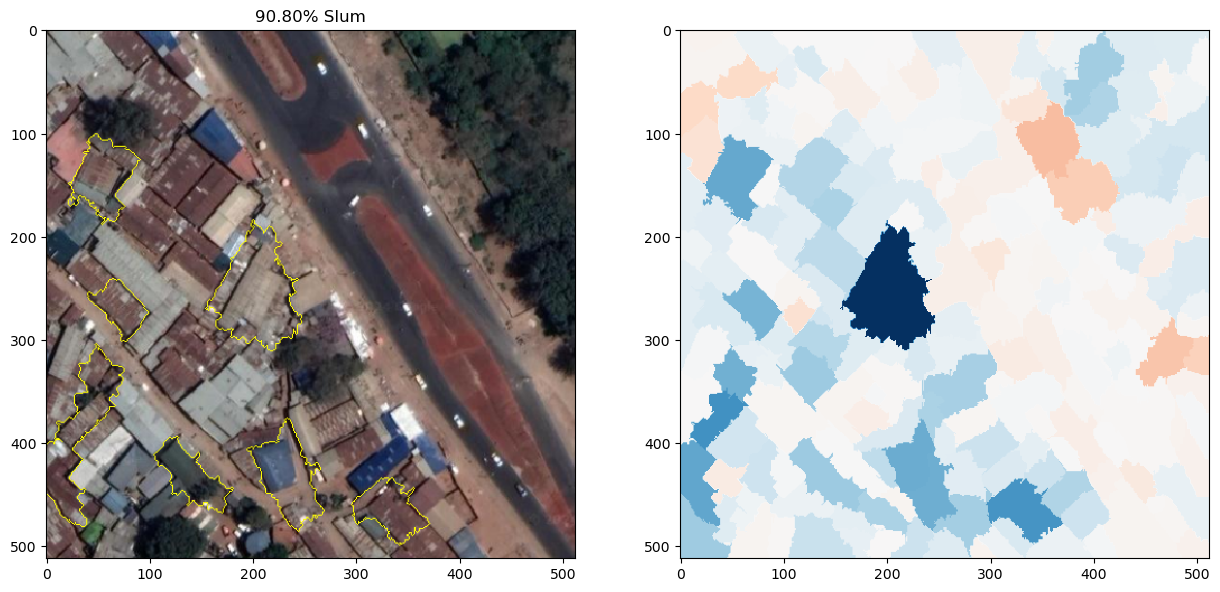

In [40]:
a = int(input("Which image would you like to see?"))
# plt.imshow(mark_boundaries(temps[a], masks[a]))
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation[a].local_exp[0])
heatmap = np.vectorize(dict_heatmap.get)(explanation[a].segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
# plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
# plt.colorbar()

fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(mark_boundaries(temps[a], masks[a]))
axes[0].set_title("%.2f" % ((probs[a])*100) + "% Slum")
axes[1].imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.show()